#Parte III - Machine Learning

Entrenar 2 (de tipos distintos, excluyendo regresiones logísticas) modelos (5 puntos cada uno) con búsqueda de hiperparametros (¿cómo conviene elegir los datos de validación respecto de los de train?). Los modelos deben cumplir las siguientes condiciones:
* Deben utilizar top-2 accuracy como métrica de validación.
* Deben medirse solo en validación, no contra test!!!
* Deben ser reproducibles (correr el notebook varias veces no afecta al resultado).
* Deben tener un score en validación superior a 0,3.
* Para el feature engineering debe utilizarse imputación de nulos, mean encoding y one hot encoding al menos una vez cada uno.
* Deben utilizar al menos 40 features (contando cómo features columnas con números, pueden venir varios de la misma variable).
* Deben utilizar CountVectorizer o TfIdfVectorizer para algunos features.
* Deberán contestar la siguiente pregunta: Para el mejor modelo de ambos, ¿cuál es el score en test? (guardar el csv con predicciones para entregarlo después)

# Modelo 1: Random Forest

In [ ]:
import pandas as pd

import random

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import top_k_accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import VotingClassifier

import xgboost as xgb

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
test_set = pd.read_parquet("/content/drive/MyDrive/Organización de Datos/TP3/Music dataset/test.parquet")
train_set = pd.read_parquet("/content/drive/MyDrive/Organización de Datos/TP3/Music dataset/train.parquet")

### Split train y validation

In [ ]:
#Hago el split de train y validation por los artistas, con una semilla para hacerlo reproducible.
#El 80% de los artistas va a train y el 20% restante a validation.
#De esta manera, se evalúa al modelo sobre artistas distintos.

artistas = train_set["artist"].unique().tolist()
random.seed(237)
random.shuffle(artistas)
artistas_20 = artistas[:2*(len(artistas)//10)]

validation = train_set[train_set["artist"].isin(artistas_20)]
train = train_set[~train_set["artist"].isin(artistas_20)]

### Imputo valores NaN de algunas columnas

In [ ]:
#OK: popularity, artist, a_songs, a_popularity, acousticness, danceability, duration_ms, energy, instrumentalness, key, liveness, loudness, mode, speechiness, tempo, time_signature, valence

#Relleno los lyrics que faltan con un string vacío
train["lyric"].fillna("", inplace=True)
test_set["lyric"].fillna("", inplace=True)
validation["lyric"].fillna("", inplace=True)

#Relleno los idiomas con el idioma más común (inglés)
language_mas_comun = train["language"].value_counts().idxmax()
train["language"].fillna(language_mas_comun, inplace=True)
test_set["language"].fillna(language_mas_comun, inplace=True)
validation["language"].fillna(language_mas_comun, inplace=True)

#Relleno s-label con el valor promedio
s_label_promedio = train["s-label"].mean()
train["s-label"].fillna(s_label_promedio, inplace=True)
test_set["s-label"].fillna(s_label_promedio, inplace=True)
validation["s-label"].fillna(s_label_promedio, inplace=True)

### Mean Encoding de la variable categórica key en función de genre

In [ ]:
keys_por_genero = train.groupby(["language", "genre"]).agg(cant_key_genero=('language','count')).reset_index()
cant_por_genero = train.groupby("genre").agg(cant_genero=('genre','count')).reset_index()

proba_key_genero = keys_por_genero.merge(cant_por_genero, on = "genre")
proba_key_genero["proba"] = proba_key_genero["cant_key_genero"] / proba_key_genero["cant_genero"]
proba_key_genero = proba_key_genero[["language", "genre", "proba"]]

proba_key_genero = proba_key_genero.pivot_table(values = "proba", index = "language", columns = "genre", fill_value = 0).add_prefix("key_")

train = train.merge(proba_key_genero, on = "language")
train.drop(["language"], axis=1, inplace=True)

validation = validation.merge(proba_key_genero, on = "language")
validation.drop(["language"], axis=1, inplace=True)

test_set = test_set.merge(proba_key_genero, on = "language")
test_set.drop(["language"], axis=1, inplace=True)

### Separo en x_train e y_train, x_validation e y_validation

In [ ]:
#Dropeo las columnas track_name, genre, artist, a_genres, did (leekean el target o no tienen sentido para predecir)

y_test = test_set["genre"]
x_test = test_set.drop(["track_name", "genre", "artist", "a_genres", "did"], axis=1, inplace=False)

y_train = train["genre"]
x_train = train.drop(["track_name", "genre", "artist", "a_genres", "did"], axis=1, inplace=False)

y_validation = validation["genre"]
x_validation = validation.drop(["track_name", "artist", "a_genres", "did"], axis=1, inplace=False)


#Saco los géneros de validation que no están en train (no se pueden predecir cosas para las que no se entrena)

generos = y_train.unique().tolist()
x_validation = x_validation[x_validation["genre"].isin(generos)]
y_validation = y_validation[y_validation.isin(generos)]
x_validation.drop(["genre"], axis=1, inplace=True)

### One Hot Encoding para variables categóricas

In [ ]:
#Variables a encodear: key (12), mode (2), time_signature (4)

x_train = x_train.reset_index().drop(["index"], axis=1)
x_validation = x_validation.reset_index().drop(["index"], axis=1)
x_test = x_test.reset_index().drop(["index"], axis=1)

def one_hot_encoding(x_train, x_validation, x_test, feature, **kwargs):
  one_hot_encoder = OneHotEncoder(**kwargs)
  
  encoded_feature_train = pd.DataFrame(one_hot_encoder.fit_transform(x_train[[feature]]).todense().astype(int))
  encoded_feature_valid = pd.DataFrame(one_hot_encoder.transform(x_validation[[feature]]).todense().astype(int))
  encoded_feature_test = pd.DataFrame(one_hot_encoder.transform(x_test[[feature]]).todense().astype(int))
  
  nombres_columnas = one_hot_encoder.get_feature_names_out()
  encoded_feature_train.columns = nombres_columnas
  encoded_feature_valid.columns = nombres_columnas
  encoded_feature_test.columns = nombres_columnas
  
  x_train = x_train.drop([feature], axis=1).join(pd.DataFrame(encoded_feature_train))
  x_validation = x_validation.drop([feature], axis=1).join(pd.DataFrame(encoded_feature_valid))
  x_test = x_test.drop([feature], axis=1).join(pd.DataFrame(encoded_feature_test))
  
  return x_train, x_validation, x_test

x_train, x_validation, x_test = one_hot_encoding(x_train, x_validation, x_test, "key")
x_train, x_validation, x_test = one_hot_encoding(x_train, x_validation, x_test, "mode", drop="first")
x_train, x_validation, x_test = one_hot_encoding(x_train, x_validation, x_test, "time_signature")

### Encoding de lyric con NLP

In [ ]:
#Feature: largo del lyric
x_train["lyric_largo"] = x_train["lyric"].apply(lambda x: len(x))
x_validation["lyric_largo"] = x_validation["lyric"].apply(lambda x: len(x))
x_test["lyric_largo"] = x_test["lyric"].apply(lambda x: len(x))

#Feature: cantidad de tokens del lyric
x_train["lyric_cant_tokens"] = x_train["lyric"].apply(lambda x: len(word_tokenize(x)))
x_validation["lyric_cant_tokens"] = x_validation["lyric"].apply(lambda x: len(word_tokenize(x)))
x_test["lyric_cant_tokens"] = x_test["lyric"].apply(lambda x: len(word_tokenize(x)))

#Feature: cantidad de tokens únicos sobre tokens totales
def tokens_unicos_sobre_totales(lyric):
  if len(word_tokenize(lyric)) != 0:
    return len(set(word_tokenize(lyric))) / len(word_tokenize(lyric))
  else:
    return 0
x_train["lyric_tokens_unicos"] = x_train["lyric"].apply(lambda x: tokens_unicos_sobre_totales(x))
x_validation["lyric_tokens_unicos"] = x_validation["lyric"].apply(lambda x: tokens_unicos_sobre_totales(x))
x_test["lyric_tokens_unicos"] = x_test["lyric"].apply(lambda x: tokens_unicos_sobre_totales(x))

#Feature: palabras por minuto
def palabras_por_minuto(lyric, duracion_ms):
  cant_tokens = len(word_tokenize(lyric))
  duracion_min = duracion_ms / 60000
  return cant_tokens / duracion_min
x_train["lyric_pal_por_minuto"] = x_train[["lyric", "duration_ms"]].apply(lambda x: palabras_por_minuto(*x), axis=1)
x_validation["lyric_pal_por_minuto"] = x_validation[["lyric", "duration_ms"]].apply(lambda x: palabras_por_minuto(*x), axis=1)
x_test["lyric_pal_por_minuto"] = x_test[["lyric", "duration_ms"]].apply(lambda x: palabras_por_minuto(*x), axis=1)

#Feature: si el lyric contiene la palabra love
x_train["lyric_tiene_love"] = x_train["lyric"].apply(lambda x: 1 if "love" in x else 0)
x_validation["lyric_tiene_love"] = x_validation["lyric"].apply(lambda x: 1 if "love" in x else 0)
x_test["lyric_tiene_love"] = x_test["lyric"].apply(lambda x: 1 if "love" in x else 0)

#Feature: si el lyric contiene la palabra yeah
x_train["lyric_tiene_yeah"] = x_train["lyric"].apply(lambda x: 1 if "yeah" in x else 0)
x_validation["lyric_tiene_yeah"] = x_validation["lyric"].apply(lambda x: 1 if "yeah" in x else 0)
x_test["lyric_tiene_yeah"] = x_test["lyric"].apply(lambda x: 1 if "yeah" in x else 0)

#Feature: si el lyric contiene la palabra blue/blues
x_train["lyric_tiene_blues"] = x_train["lyric"].apply(lambda x: 1 if ("blue" in x or "blues" in x) else 0)
x_validation["lyric_tiene_blues"] = x_validation["lyric"].apply(lambda x: 1 if ("blue" in x or "blues" in x) else 0)
x_test["lyric_tiene_blues"] = x_test["lyric"].apply(lambda x: 1 if ("blue" in x or "blues" in x) else 0)

TF-IDF

In [ ]:
#Al final no terminé utilizando TF-IDF porque empeora la performance del modelo.
#Sólo utilicé Count Vectorizer.

"""stopwords_esp = set(stopwords.words('spanish'))
stopwords_en = set(stopwords.words('english'))
stopwords_en_esp = stopwords_en | stopwords_esp
count_IDF = TfidfVectorizer(lowercase = True, stop_words = stopwords_en_esp, max_features = 10)

matriz_vectores_IDF_train = count_IDF.fit_transform(x_train["lyric"])
df_vectores_IDF_train = pd.DataFrame(matriz_vectores_IDF_train.toarray(), columns = count_IDF.get_feature_names_out())
x_train = x_train.join(df_vectores_IDF_train)

matriz_vectores_IDF_valid = count_IDF.transform(x_validation["lyric"])
df_vectores_IDF_valid = pd.DataFrame(matriz_vectores_IDF_valid.toarray(), columns = count_IDF.get_feature_names_out())
x_validation = x_validation.join(df_vectores_IDF_train)

matriz_vectores_IDF_test = count_IDF.transform(x_test["lyric"])
df_vectores_IDF_test = pd.DataFrame(matriz_vectores_IDF_test.toarray(), columns = count_IDF.get_feature_names_out())
x_test = x_test.join(df_vectores_IDF_train)"""

Count Vectorizer

In [ ]:
stopwords_esp = set(stopwords.words('spanish'))
stopwords_en = set(stopwords.words('english'))
stopwords_en_esp = stopwords_en | stopwords_esp

count_vec = CountVectorizer(lowercase = True, stop_words = stopwords_en_esp, max_features = 10)
matriz_vectores_count_vec = count_vec.fit_transform(x_train["lyric"])
palabras_mayor_count = pd.DataFrame(matriz_vectores_count_vec.toarray(), columns = count_vec.get_feature_names_out()).columns.tolist()

#Saco de la lista las palabras love y yeah que ya las había utilizado para hacer features
palabras_mayor_count.remove("love")
palabras_mayor_count.remove("yeah")

for palabra in palabras_mayor_count:
  x_train["lyric_tiene_" + palabra] = x_train["lyric"].apply(lambda x: 1 if palabra in x else 0)
  x_validation["lyric_tiene_" + palabra] = x_validation["lyric"].apply(lambda x: 1 if palabra in x else 0)
  x_test["lyric_tiene_" + palabra] = x_test["lyric"].apply(lambda x: 1 if palabra in x else 0)

In [ ]:
#Dropeo la columna lyric una vez obtenidas las features
x_train.drop(["lyric"], axis=1, inplace=True)
x_validation.drop(["lyric"], axis=1, inplace=True)
x_test.drop(["lyric"], axis=1, inplace=True)

### Entrenamiento de un modelo de Random Forest con hiperparámetros default (modelo sin TF-IDF):

In [ ]:
modelo = RandomForestClassifier(random_state = 237)

modelo.fit(x_train, y_train)

proba_preds = modelo.predict_proba(x_validation)

top_k_accuracy_score(y_validation, proba_preds, k=2, labels=modelo.classes_)

0.5509493670886076



---



### Búsqueda de hiperparámetros con Random Search (modelo con TF-IDF):

In [ ]:
modelo = RandomForestClassifier(random_state = 237)

hiperparams = {"n_estimators": [25, 50, 100, 150, 200], "criterion" : ["gini", "entropy", "log_loss"], "max_depth": [None, 10, 50, 100], "min_samples_split": [10, 25, 50],
               "min_samples_leaf": [1, 2, 5, 10], "min_weight_fraction_leaf": [0.0, 0.1, 0.5], "max_features": ["sqrt", "log2", None, 2, 5, 10]}
random_search = RandomizedSearchCV(modelo, hiperparams, n_iter=100, random_state=237)
search = random_search.fit(x_train, y_train)

In [ ]:
search.best_params_

{'n_estimators': 150,
 'min_weight_fraction_leaf': 0.0,
 'min_samples_split': 25,
 'min_samples_leaf': 2,
 'max_features': None,
 'max_depth': None,
 'criterion': 'gini'}

Predicciones para valid con el nuevo modelo con los hiperparámetros encontrados:

In [ ]:
modelo_mejorado = search.best_estimator_
proba_preds = modelo_mejorado.predict_proba(x_validation)
top_k_accuracy_score(y_validation, proba_preds, k=2, labels=modelo_mejorado.classes_)

0.5400316455696202

### Refino la búsqueda de hiperparámetros:

In [ ]:
modelo = RandomForestClassifier(random_state = 237)

hiperparams = {"n_estimators": [150, 200, 300], "criterion" : ["gini"], "max_depth": [None, 200, 300], "min_samples_split": [2, 4, 20],
               "min_samples_leaf": [1, 2, 3], "min_weight_fraction_leaf": [0.0], "max_features": ["sqrt", "log2", None, 5, 10]}
random_search = RandomizedSearchCV(modelo, hiperparams, n_iter=50, random_state=237)
search = random_search.fit(x_train, y_train)

In [ ]:
search.best_params_

{'n_estimators': 150,
 'min_weight_fraction_leaf': 0.0,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': None,
 'max_depth': 200,
 'criterion': 'gini'}

Predicciones para valid con el nuevo modelo con los hiperparámetros encontrados:

In [ ]:
modelo_mejorado = search.best_estimator_
proba_preds = modelo_mejorado.predict_proba(x_validation)
top_k_accuracy_score(y_validation, proba_preds, k=2, labels=modelo_mejorado.classes_)

0.5349683544303797

Luego de dos Random Search (uno de 3 horas y otro de 6 horas refinando sobre el anterior) no pude encontrar mejores hiperparámetros que los default. Pruebo sin utilizar el encoding de TF-IDF ya que sospecho que confunde el modelo al obtener un score menor.



---



### Búsqueda de hiperparámetros con Random Search (modelo sin TF-IDF):

In [ ]:
modelo = RandomForestClassifier(random_state = 237)

hiperparams = {"n_estimators": [300, 500, 1000], "criterion" : ["gini", "entropy"], "max_depth": [None, 100, 150, 200], "min_samples_split": [2, 6, 8],
               "min_samples_leaf": [2, 3], "min_weight_fraction_leaf": [0.0], "max_features": ["sqrt", "log2", None, 5, 10]}
random_search = RandomizedSearchCV(modelo, hiperparams, n_iter=50, random_state=237)
search = random_search.fit(x_train, y_train)

In [ ]:
search.best_params_

{'n_estimators': 500,
 'min_weight_fraction_leaf': 0.0,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': None,
 'max_depth': 150,
 'criterion': 'entropy'}

Predicciones para valid con el nuevo modelo con los hiperparámetros encontrados:

In [ ]:
modelo_mejorado = search.best_estimator_
proba_preds = modelo_mejorado.predict_proba(x_validation)
top_k_accuracy_score(y_validation, proba_preds, k=2, labels=modelo_mejorado.classes_)

0.5156645569620253

### Refino la búsqueda de hiperparámetros, esta vez me acerco más a los hiperparámetros default que fueron los que mejor resultado me dieron, pero aumentando aquellos valores que deberían dar mejor performance, pero con un mayor costo de tiempo:

In [ ]:
modelo = RandomForestClassifier(random_state = 237)

hiperparams = {"n_estimators": [200, 300], "criterion" : ["gini", "entropy"], "max_depth": [None, 200], "min_samples_split": [2, 4],
               "min_samples_leaf": [1, 2], "min_weight_fraction_leaf": [0.0], "max_features": ["sqrt", 10]}
random_search = RandomizedSearchCV(modelo, hiperparams, n_iter=30, cv=3, random_state=237)
search = random_search.fit(x_train, y_train)

In [ ]:
search.best_params_

{'n_estimators': 300,
 'min_weight_fraction_leaf': 0.0,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 10,
 'max_depth': 200,
 'criterion': 'gini'}

Predicciones para valid con el nuevo modelo con los hiperparámetros encontrados:

In [ ]:
modelo_mejorado = search.best_estimator_
proba_preds = modelo_mejorado.predict_proba(x_validation)
top_k_accuracy_score(y_validation, proba_preds, k=2, labels=modelo_mejorado.classes_)

0.5626582278481013

Este es mi mejor modelo de Random Forest, y dio un score un poco mejor para validation que XGBoost (modelo 2), entonces lo uso para predecir en test

### Predicciones para test:

In [ ]:
proba_preds = modelo_mejorado.predict_proba(x_test)
top_k_accuracy_score(y_test, proba_preds, k=2, labels=modelo_mejorado.classes_)

0.529113067027759

### Guardo las predicciones para test en un CSV

In [ ]:
predicciones = pd.DataFrame(proba_preds)
predicciones.columns = modelo_mejorado.classes_
predicciones_test = x_test.join(predicciones)
predicciones_test.to_csv("/content/drive/MyDrive/Organización de Datos/TP3/predicciones_test_RF.csv")

# Punto extra: feature importance

Graficar la importancia de features para algún modelo de la parte III. ¿Qué tanto se parece a los features importantes de la parte II?

In [ ]:
feature_importance = pd.DataFrame(modelo_mejorado.feature_importances_)
feature_importance.columns = ["importance"]
feature_importance["features"] = x_train.columns
feature_importance

features_importantes = feature_importance.nlargest(15, "importance")
features_importantes

,importance,features
0,0.189803,popularity
1,0.059179,a_songs
2,0.055416,a_popularity
4,0.049318,acousticness
58,0.045739,lyric_pal_por_minuto
7,0.043007,energy
55,0.041751,lyric_largo
56,0.041567,lyric_cant_tokens
5,0.041527,danceability
11,0.041223,speechiness


Text(0.5, 1.0, 'Features más importantes')

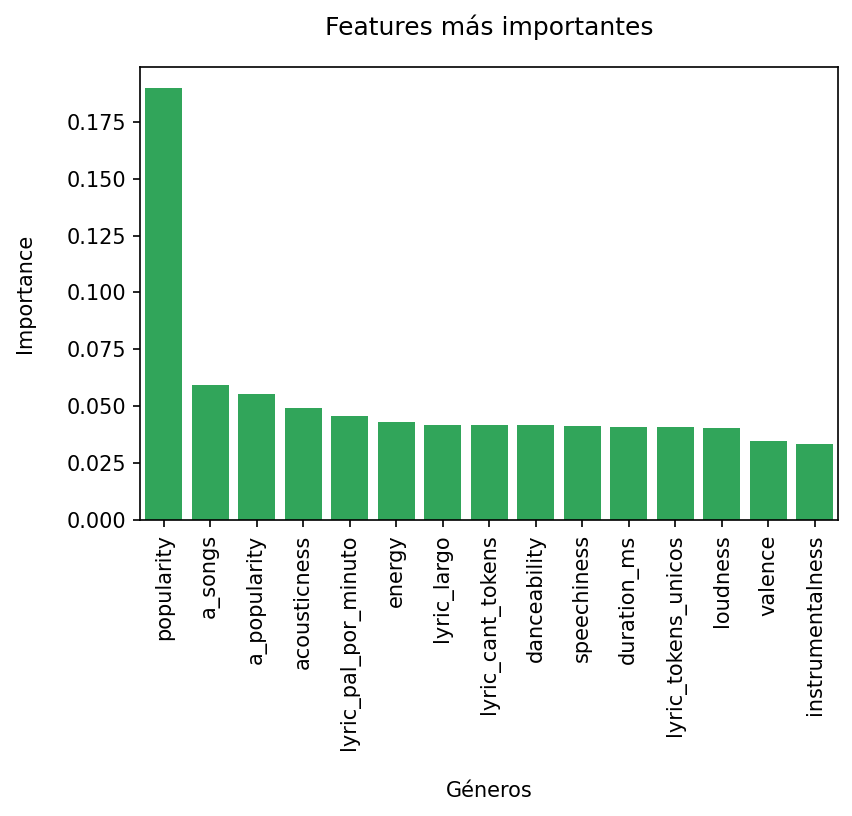

In [ ]:
plt.figure(dpi=150)
sns.barplot(data=features_importantes, x="features", y="importance", color="#1DB954")
plt.xticks(rotation=90)
plt.xlabel("Géneros", labelpad=15)
plt.ylabel("Importance", labelpad=15)
plt.title("Features más importantes", pad=15)

Vemos que las features más importantes se parecen bastante a la de la parte 1, pero con algunas diferencias. En este modelo popularity tiene mucha más importancia que todas las demás features, y no se tiene muy en cuenta a los idiomas, a diferencia de Logistic Regression. Además, aparecen aquí algunas de las features nuevas que no estaban en la parte 2.

# Punto extra: ensamble

Ensamble ambos modelos de la parte III en uno solo. ¿Cúal es su score en validación y en test?

In [ ]:
#Ejecuto mi segundo modelo, XGBoost:

modelo_XGB = xgb.XGBClassifier(random_state = 237, learning_rate = 0.09, max_depth = 4, subsample = 0.8, colsample_bytree = 0.95,
                               n_estimators = 85, gamma = 0, reg_alpha = 0.15, reg_lambda = 0.9)

modelo_XGB.fit(x_train, y_train)

In [ ]:
#Utilizo mi primer modelo, Random Forest:

modelo_RF = modelo_mejorado

Para el ensamble, utilizo VotingClassifier de sklearn con voting soft para obtener las proba preds

In [ ]:
ensamble = VotingClassifier(estimators=[('RF', modelo_RF), ('XGB', modelo_XGB)], voting='soft')
ensamble = ensamble.fit(x_train, y_train)

Predicciones para validation:

In [ ]:
proba_preds_ensamble = ensamble.predict_proba(x_validation)
top_k_accuracy_score(y_validation, proba_preds_ensamble, k=2, labels=ensamble.classes_)

0.5686708860759494

Da un score levemente mayor al mejor de mis modelos (Random Forest)

Predicciones para test:

In [ ]:
proba_preds_ensamble = ensamble.predict_proba(x_test)
top_k_accuracy_score(y_test, proba_preds_ensamble, k=2, labels=ensamble.classes_)

0.529113067027759

Da el mismo score que el mejor de mis modelos (Random Forest)